# Brazilian E-Commerce Data Analysis

In [13]:
# Importing necessary libraries for data manipulation and visualization

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Loading all the datasets:

customers = pd.read_csv("/data/notebook_files/olist_customers_dataset.csv")
geolocation = pd.read_csv("/data/notebook_files/olist_geolocation_dataset.csv")
order_items = pd.read_csv("/data/notebook_files/olist_order_items_dataset.csv")
order_payments = pd.read_csv("/data/notebook_files/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("/data/notebook_files/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/data/notebook_files/olist_orders_dataset.csv")
products = pd.read_csv("/data/notebook_files/olist_products_dataset.csv")
sellers = pd.read_csv("/data/notebook_files/olist_sellers_dataset.csv")

In [4]:
# I want to get a sense of the size of each dataset.
# By checking the shape, I'll know how many rows and columns I have in each one, which will give me a good starting point.

initial_shapes = {
    "customers": customers.shape,
    "geolocation": geolocation.shape,
    "order_items": order_items.shape,
    "order_payments": order_payments.shape,
    "order_reviews": order_reviews.shape,
    "orders": orders.shape,
    "products": products.shape,
    "sellers": sellers.shape
}

initial_shapes

{'customers': (99441, 5),
 'geolocation': (1000163, 5),
 'order_items': (112650, 7),
 'order_payments': (103886, 5),
 'order_reviews': (99224, 7),
 'orders': (99441, 8),
 'products': (32951, 9),
 'sellers': (3095, 4)}

In [6]:
# To ensure the accuracy of my analysis, I need to use complete and reliable data.
# I've noticed that data from August 2018 onwards is incomplete.
# To tackle this, I'm going to focus on the data up to July 2018.

# I'm setting July 2018 as my cutoff date.
cutoff_date = '2018-07-31'

# Now, I'll filter out orders made after my cutoff date.
orders_cleaned = orders[orders['order_purchase_timestamp'] <= cutoff_date]

# For the customers dataset, I'm going to keep only those who made purchases before my cutoff date.
customers_cleaned = customers[customers['customer_id'].isin(orders_cleaned['customer_id'])]

# The geolocation data is not dependent on the order dates, so I'll leave it as it is.
geolocation_cleaned = geolocation

# I'm doing a similar cleanup for other datasets, ensuring they align with the refined orders.
order_items_cleaned = order_items[order_items['order_id'].isin(orders_cleaned['order_id'])]
order_payments_cleaned = order_payments[order_payments['order_id'].isin(orders_cleaned['order_id'])]
order_reviews_cleaned = order_reviews[order_reviews['order_id'].isin(orders_cleaned['order_id'])]
products_cleaned = products[products['product_id'].isin(order_items_cleaned['product_id'])]
sellers_cleaned = sellers[sellers['seller_id'].isin(order_items_cleaned['seller_id'])]

# To double-check my work, I want to see the size of my cleaned datasets.
# This will give me a quick overview and confirm that I've streamlined the data correctly.
cleaned_shapes = {
    "customers": customers_cleaned.shape,
    "geolocation": geolocation_cleaned.shape,
    "order_items": order_items_cleaned.shape,
    "order_payments": order_payments_cleaned.shape,
    "order_reviews": order_reviews_cleaned.shape,
    "orders": orders_cleaned.shape,
    "products": products_cleaned.shape,
    "sellers": sellers_cleaned.shape
}

cleaned_shapes

{'customers': (92587, 5),
 'geolocation': (1000163, 5),
 'order_items': (105024, 7),
 'order_payments': (96837, 5),
 'order_reviews': (92399, 7),
 'orders': (92587, 8),
 'products': (30758, 9),
 'sellers': (2932, 4)}

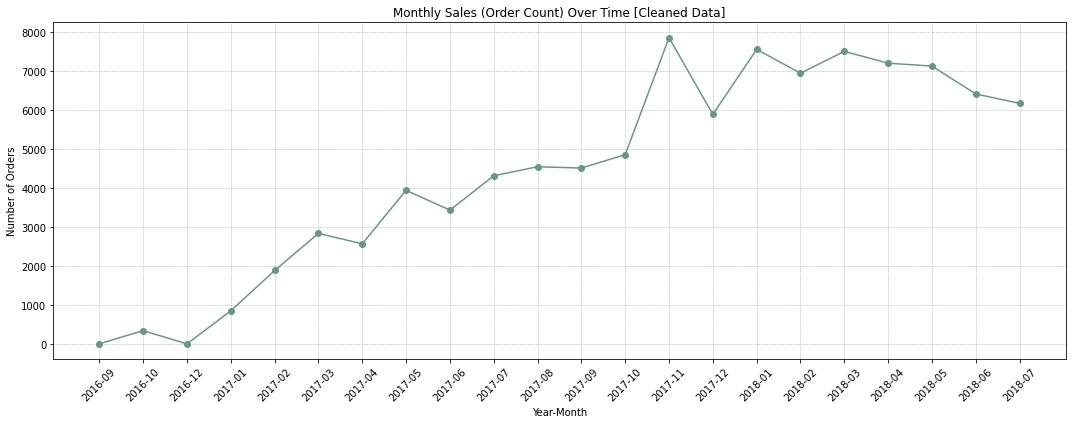

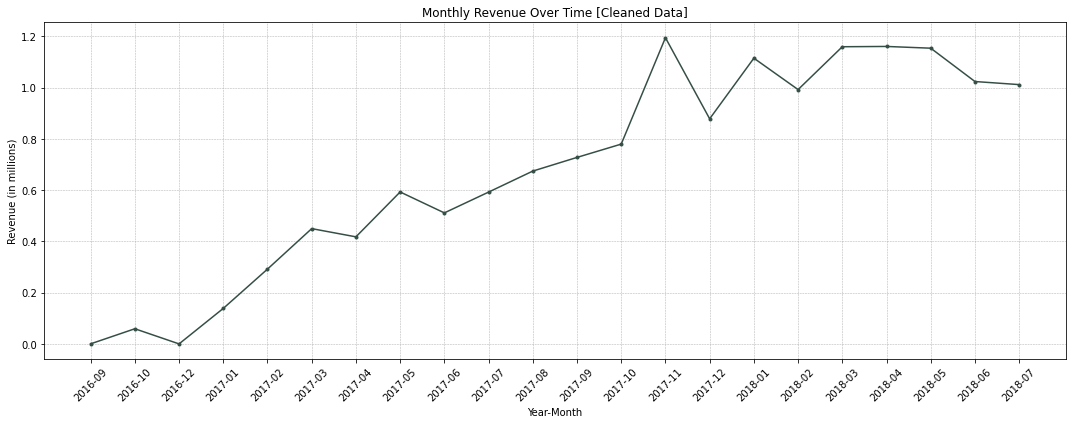

In [7]:
# After cleaning the data, I aim to get a sense of how the e-commerce market in Brazil has been performing over time.
# Specifically, I want to understand the monthly sales and revenue trends.
# This will help in gauging the overall attractiveness of the market.

# First, I'll merge the orders and payment datasets to associate order dates with payment values.
order_revenue_cleaned = orders_cleaned.merge(order_payments_cleaned, on='order_id', how='inner')

# To visualize trends over time, it's helpful to group data by months.
# I'll extract the year and month from the order timestamps for this purpose.
order_revenue_cleaned['year_month'] = order_revenue_cleaned['order_purchase_timestamp'].astype('datetime64[ns]').dt.to_period('M')

# With the data now having a 'year_month' column, I'll group by it to get monthly sales counts and total revenue.
monthly_sales_revenue_cleaned = order_revenue_cleaned.groupby('year_month').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).rename(columns={'order_id': 'num_orders'}).reset_index()

# Let's visualize the trends. First up, monthly sales:

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales_revenue_cleaned['year_month'].astype(str), monthly_sales_revenue_cleaned['num_orders'], marker='o', linestyle='-', color='#679787', label='Monthly Sales (Order Count)')
plt.xticks(rotation=45)
plt.title('Monthly Sales (Order Count) Over Time [Cleaned Data]')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Next, I'll visualize the monthly revenue trends:

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales_revenue_cleaned['year_month'].astype(str), monthly_sales_revenue_cleaned['payment_value'] / 1_000_000, marker='.', linestyle='-', color='#354e46', label='Monthly Revenue')
plt.xticks(rotation=45)
plt.title('Monthly Revenue Over Time [Cleaned Data]')
plt.xlabel('Year-Month')
plt.ylabel('Revenue (in millions)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# These visualizations will give a clear picture of how the market has been growing and whether it presents a lucrative opportunity.

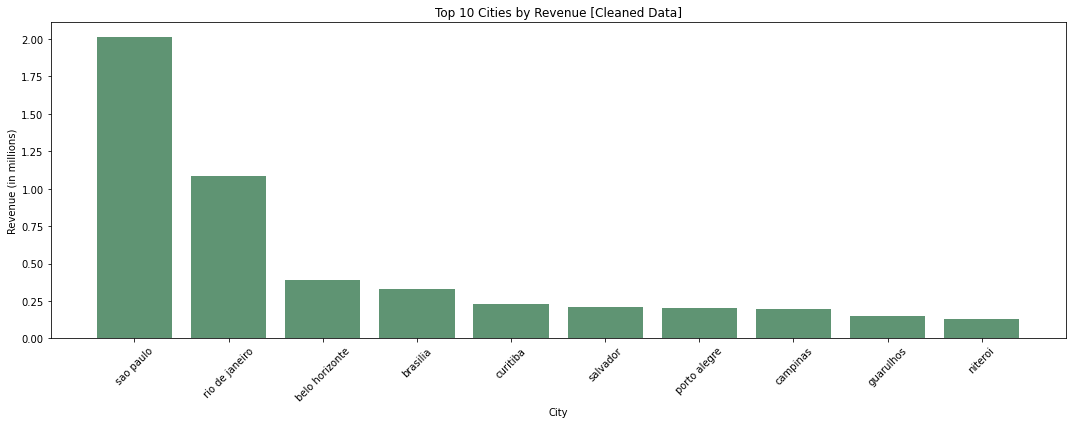

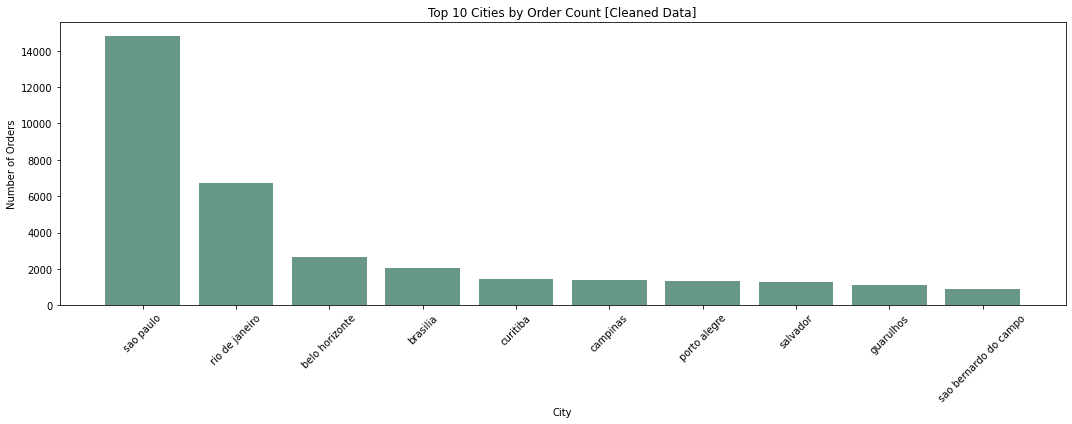

In [8]:
# Now, I want to determine which cities are the top contributors to the e-commerce market in terms of revenue and order count.
# This will help in understanding the geographic distribution of the market and identifying potential hotspots.

# First, I'll merge the cleaned orders dataset with the cleaned customers dataset.
# This will associate each order with its respective city.
order_city_cleaned = orders_cleaned.merge(customers_cleaned, on='customer_id', how='inner')

# Next, I'll merge this combined dataset with the order payments dataset.
# This will allow me to associate each order's city with its respective payment value.
order_city_revenue_cleaned = order_city_cleaned.merge(order_payments_cleaned, on='order_id', how='inner')

# Now, I'll group the data by city to calculate the total revenue and order count for each city.
city_sales_revenue = order_city_revenue_cleaned.groupby('customer_city').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).rename(columns={'order_id': 'num_orders'}).reset_index()

# To identify the top cities, I'll sort the data based on revenue and order count, respectively.
top_cities_revenue = city_sales_revenue.sort_values(by='payment_value', ascending=False).head(10)
top_cities_orders = city_sales_revenue.sort_values(by='num_orders', ascending=False).head(10)

# Let's visualize the top cities by revenue:
plt.figure(figsize=(15, 6))
plt.bar(top_cities_revenue['customer_city'], top_cities_revenue['payment_value'] / 1_000_000, color='#5f9473')
plt.xticks(rotation=45)
plt.title('Top 10 Cities by Revenue [Cleaned Data]')
plt.xlabel('City')
plt.ylabel('Revenue (in millions)')
plt.tight_layout()
plt.show()

# Now, let's visualize the top cities by order count:
plt.figure(figsize=(15, 6))
plt.bar(top_cities_orders['customer_city'], top_cities_orders['num_orders'], color='#679787')
plt.xticks(rotation=45)
plt.title('Top 10 Cities by Order Count [Cleaned Data]')
plt.xlabel('City')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

# These visualizations will highlight the cities that are key contributors to the e-commerce market in Brazil.
# They will be instrumental in making location-specific decisions for business expansion or targeting.

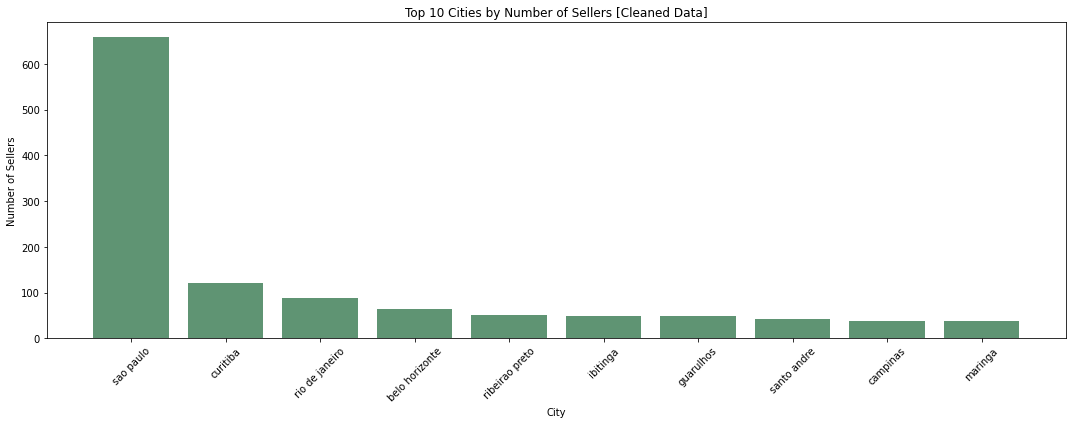

In [9]:
# After analyzing the top cities by revenue and order count, I'm now curious about the distribution of sellers.
# Specifically, I want to identify which cities have the highest concentration of sellers.
# This information is crucial as it can provide insights into the competitive landscape of the e-commerce market in Brazil.

# First, I'll group the sellers' data by city to calculate the number of unique sellers for each city.
sellers_per_city = sellers_cleaned.groupby('seller_city').agg({
    'seller_id': 'nunique'
}).rename(columns={'seller_id': 'num_sellers'}).reset_index()

# To identify the top cities, I'll sort the data based on the number of sellers.
top_seller_cities = sellers_per_city.sort_values(by='num_sellers', ascending=False).head(10)

# Now, I'll visualize the top cities in terms of the number of sellers.
# This will give a clear picture of where the majority of the sellers are based.
plt.figure(figsize=(15, 6))
plt.bar(top_seller_cities['seller_city'], top_seller_cities['num_sellers'], color='#5f9473')
plt.xticks(rotation=45)
plt.title('Top 10 Cities by Number of Sellers [Cleaned Data]')
plt.xlabel('City')
plt.ylabel('Number of Sellers')
plt.tight_layout()
plt.show()

# This visualization will help in understanding the distribution of sellers across cities.
# It will also highlight potential areas where there might be higher competition due to a greater concentration of sellers.

In [10]:
# After identifying Rio de Janeiro as a potential location for our client's business, 
# I'm interested in diving deeper into the product categories that are most popular in Rio.

# First, I'll filter out the orders specific to Rio de Janeiro to narrow down the analysis.
orders_rio = order_city_revenue_cleaned[order_city_revenue_cleaned['customer_city'] == 'rio de janeiro']

# Next, I'll merge this filtered dataset with order_items_cleaned to fetch the product details for each order.
orders_rio_products = orders_rio.merge(order_items_cleaned, on='order_id', how='inner')

# To get the product category for each product, I'll perform another merge with the products_cleaned dataset.
orders_rio_categories = orders_rio_products.merge(products_cleaned, on='product_id', how='inner')

# Now, I'll group by product category to compute the total revenue and the number of products sold for each category.
category_sales_revenue = orders_rio_categories.groupby('product_category_name').agg({
    'payment_value': 'sum',
    'order_id': 'count'
}).rename(columns={'order_id': 'num_products_sold'}).reset_index()

# To identify the top-performing product categories, I'll sort the data by revenue and the number of products sold.
top_categories_revenue = category_sales_revenue.sort_values(by='payment_value', ascending=False).head(10)
top_categories_products = category_sales_revenue.sort_values(by='num_products_sold', ascending=False).head(10)

# Displaying the top product categories based on revenue and number of products sold.
top_categories_revenue, top_categories_products

# These insights will provide a clearer picture of which product categories are in high demand in Rio.
# This can guide our client in making informed decisions about their product offerings in the city.

(     product_category_name  payment_value  num_products_sold
 12         cama_mesa_banho      121833.64                863
 65          telefonia_fixa      112491.22                 24
 31           esporte_lazer      103405.80                568
 61      relogios_presentes      101138.43                448
 41  informatica_acessorios       98932.14                526
 50        moveis_decoracao       97595.68                620
 10            beleza_saude       97126.52                539
 51       moveis_escritorio       80838.44                239
 66   utilidades_domesticas       69254.63                449
 11              brinquedos       54862.84                341,
      product_category_name  payment_value  num_products_sold
 12         cama_mesa_banho      121833.64                863
 50        moveis_decoracao       97595.68                620
 31           esporte_lazer      103405.80                568
 10            beleza_saude       97126.52                539
 41  in

In [11]:
# With the aim of understanding the competitive landscape for the most popular product categories in Rio,
# I will determine the number of unique sellers for each of the top 5 product categories by the number of products sold.

# First, I'll extract the names of the top 5 product categories.
top_5_categories = top_categories_products['product_category_name'].head(5).tolist()

# Then, I'll filter the merged dataset (orders_rio_categories) to retain only the records corresponding to these top 5 categories.
top_categories_rio = orders_rio_categories[orders_rio_categories['product_category_name'].isin(top_5_categories)]

# Next, I'll group the filtered data by product category and count the number of unique sellers for each category.
# This will give us an idea of how many sellers are operating in each of these top categories in Rio.
sellers_per_top_category = top_categories_rio.groupby('product_category_name').agg({
    'seller_id': 'nunique'
}).reset_index().sort_values(by='seller_id', ascending=False)

# Displaying the number of unique sellers for each of the top 5 product categories.
sellers_per_top_category

# By knowing the number of sellers in each category, our client can gauge the level of competition and 
# strategically position themselves in the market.

,product_category_name,seller_id
2,esporte_lazer,158
0,beleza_saude,132
4,moveis_decoracao,124
3,informatica_acessorios,94
1,cama_mesa_banho,86


In [12]:
# Given the importance of understanding the competitive landscape in Rio de Janeiro, 
# I aim to identify how many sellers are based in Rio and how many are based outside of Rio for the top product categories.

# To start, I'm going to mark each seller in our sellers_cleaned dataset with a flag indicating whether they are based in Rio or not.
sellers_cleaned['is_based_in_rio'] = sellers_cleaned['seller_city'] == 'rio de janeiro'

# Once the sellers are marked, I'll merge this information with our top_categories_rio dataset.
# This way, for each order from Rio in the top categories, we'll know whether the seller is based in Rio or not.
top_categories_rio_sellers = top_categories_rio.merge(sellers_cleaned[['seller_id', 'is_based_in_rio']], on='seller_id', how='left')

# Now, I'll group the data by product category and the Rio-based flag. This will allow us to count 
# the number of unique sellers for each category, split by whether they are based in Rio or not.
sellers_location_per_top_category = top_categories_rio_sellers.groupby(['product_category_name', 'is_based_in_rio']).agg({
    'seller_id': 'nunique'
}).reset_index()

# To make the data more readable, I'll pivot the table so that we can see the number of sellers based in Rio 
# and those based outside of Rio side by side for each product category.
sellers_by_location = sellers_location_per_top_category.pivot(index='product_category_name', columns='is_based_in_rio', values='seller_id').fillna(0).reset_index()

# Displaying the data to better understand the distribution of sellers for top product categories in Rio.
sellers_by_location

# This information is invaluable for our client. By understanding where the competition is based, 
# they can make more informed decisions about their market entry strategy.

<ipython-input-12-9d240f4e45de>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sellers_cleaned['is_based_in_rio'] = sellers_cleaned['seller_city'] == 'rio de janeiro'


is_based_in_rio,product_category_name,False,True
0,beleza_saude,124,8
1,cama_mesa_banho,85,1
2,esporte_lazer,147,11
3,informatica_acessorios,93,1
4,moveis_decoracao,120,4


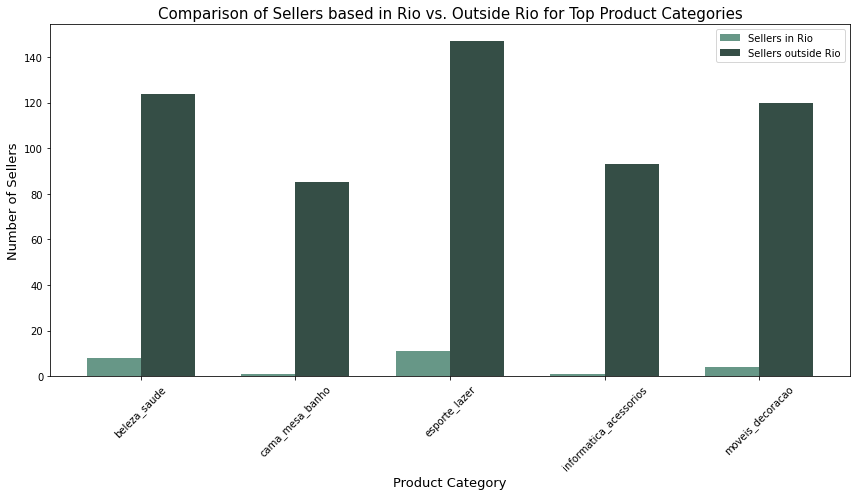

In [14]:
# I will start by defining the product categories and the corresponding number of sellers in and outside Rio.
categories = ['beleza_saude', 'cama_mesa_banho', 'esporte_lazer', 'informatica_acessorios', 'moveis_decoracao']
in_rio = [8, 1, 11, 1, 4]  # Number of sellers based in Rio
outside_rio = [124, 85, 147, 93, 120]  # Number of sellers based outside Rio

# Setting the width for each bar in the chart
bar_width = 0.35

# Generating index values for each category. This will help in placing the bars on the x-axis.
index = np.arange(len(categories))

# Initializing the figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 7))

# Now, I'll plot two sets of bars - one for sellers in Rio and another for sellers outside Rio.
# The colors '#679787' and '#354e46' are used to differentiate between the two.
bar1 = ax.bar(index, in_rio, bar_width, label='Sellers in Rio', color='#679787')
bar2 = ax.bar(index + bar_width, outside_rio, bar_width, label='Sellers outside Rio', color='#354e46')

# Adding a title and labels to the x-axis and y-axis for clarity.
ax.set_title('Comparison of Sellers based in Rio vs. Outside Rio for Top Product Categories', fontsize=15)
ax.set_xlabel('Product Category', fontsize=13)
ax.set_ylabel('Number of Sellers', fontsize=13)

# Setting the position of the x-tick labels to be centered between the two bars of each category.
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=45)  # Rotating the category names for better readability

# Finally, adding a legend to the chart to indicate which color corresponds to sellers in Rio and which one to those outside Rio.
ax.legend()

# Ensuring the layout is clean and all elements are visible without overlap.
plt.tight_layout()

# Displaying the final visualization.
plt.show()

# This visualization gives a clear and immediate understanding of the distribution of sellers for the top product categories in Rio.

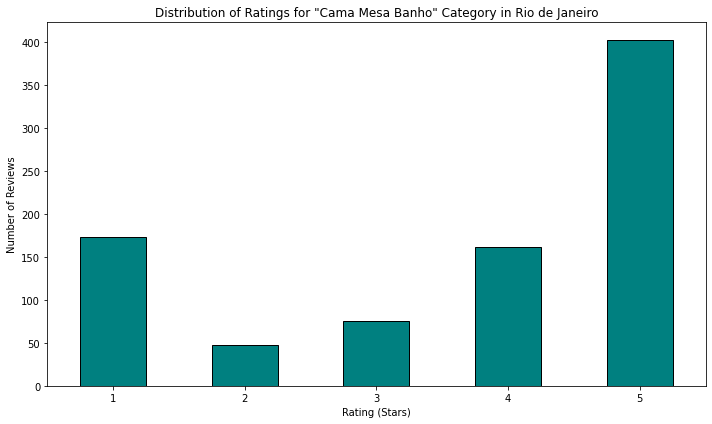

1 173
2 47
3 76
4 162
5 403
Name: review_score, dtype: int64

In [15]:
# First, I'll filter out orders from Rio de Janeiro that are specifically related to the "Cama Mesa Banho" product category.
cama_mesa_banho_orders = orders_rio_categories[orders_rio_categories['product_category_name'] == 'cama_mesa_banho']

# Next, to understand the customer feedback, I'll merge this filtered data with the cleaned order reviews dataset.
# This will allow us to associate each order with its corresponding review score.
cama_mesa_banho_reviews = cama_mesa_banho_orders.merge(order_reviews_cleaned, on='order_id', how='inner')

# I'll then tally the number of times each rating (from 1 to 5 stars) was given by customers.
rating_distribution = cama_mesa_banho_reviews['review_score'].value_counts().sort_index()

# Now, let's visualize this data. I'll plot a bar chart to showcase the distribution of ratings.
plt.figure(figsize=(10, 6))  # Setting up the canvas size for the plot
rating_distribution.plot(kind='bar', color='teal', edgecolor='black')  # Bar chart with teal bars and black edges

# Adding a title and labels for clarity.
plt.title('Distribution of Ratings for "Cama Mesa Banho" Category in Rio de Janeiro')
plt.xlabel('Rating (Stars)')
plt.ylabel('Number of Reviews')

# Setting the rotation of the x-axis labels (ratings) to 0 for better readability.
plt.xticks(rotation=0)

# Adjusting the layout for clarity and to ensure all elements fit well.
plt.tight_layout()

# Displaying the final visualization.
plt.show()

# Finally, I'll display the exact count of each rating for reference.
rating_distribution

# This visualization and data give a clear picture of customer satisfaction for the "Cama Mesa Banho" category in Rio.
# It helps in understanding which ratings are most common and where potential areas of improvement might lie.

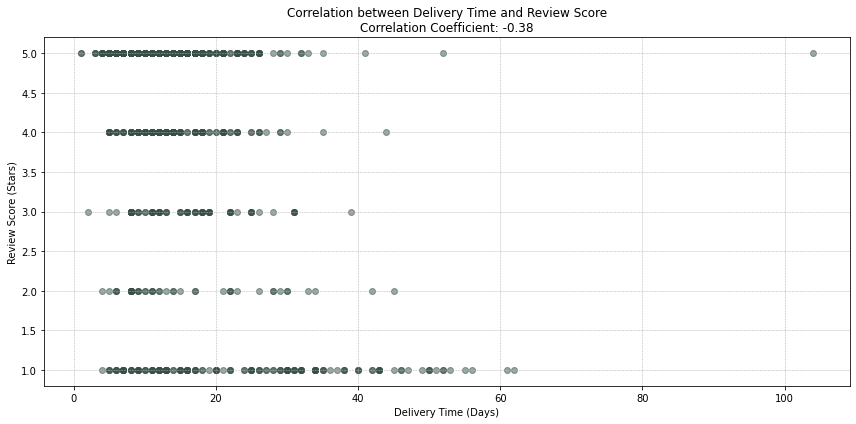

-0.3845724314788655

In [16]:
# I'll begin by calculating the delivery duration for each order. 
# This is done by subtracting the purchase timestamp from the delivery date.
cama_mesa_banho_reviews['delivery_time_days'] = (cama_mesa_banho_reviews['order_delivered_customer_date'].astype('datetime64[ns]') - 
                                                cama_mesa_banho_reviews['order_purchase_timestamp'].astype('datetime64[ns]')).dt.days

# After calculating the delivery times, I'm interested in understanding if there's any relationship 
# between how long a customer waits for their order and how they rate the product.
# For this, I'll compute the correlation coefficient between delivery times and review scores.
correlation = cama_mesa_banho_reviews[['delivery_time_days', 'review_score']].corr().iloc[0, 1]

# Now, I'll visualize this relationship using a scatter plot.
plt.figure(figsize=(12, 6))  # Setting up the canvas size for the plot
plt.scatter(cama_mesa_banho_reviews['delivery_time_days'], cama_mesa_banho_reviews['review_score'], alpha=0.5, color='#354e46')  # Plotting the data points

# Adding a title that also displays the calculated correlation coefficient for context.
plt.title(f'Correlation between Delivery Time and Review Score\nCorrelation Coefficient: {correlation:.2f}')
plt.xlabel('Delivery Time (Days)')  # Label for the x-axis
plt.ylabel('Review Score (Stars)')  # Label for the y-axis

# Adjusting the layout for clarity and ensuring all elements fit well.
plt.tight_layout()

# Adding a grid for better readability.
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Displaying the visualization.
plt.show()

# Finally, I'll output the exact correlation value for reference.
correlation

# This analysis helps gauge whether extended delivery times are impacting customer satisfaction.
# If the correlation is negative, it would suggest that longer delivery times are associated with lower review scores.

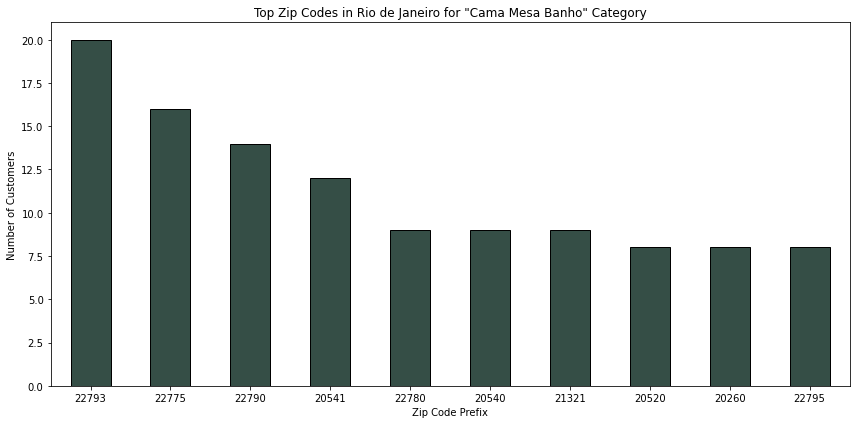

,customer_zip_code_prefix,num_customers
196,22793,20
191,22775,16
195,22790,14
29,20541,12
192,22780,9
28,20540,9
75,21321,9
24,20520,8
18,20260,8
197,22795,8


In [17]:
# I'll start by narrowing down our dataset to only those orders from Rio de Janeiro that are related to the "Cama Mesa Banho" category.
# This helps in focusing on our area and product of interest.
cama_mesa_banho_rio = cama_mesa_banho_orders[cama_mesa_banho_orders['customer_city'] == 'rio de janeiro']

# With this filtered dataset, I want to understand which specific areas (or zip codes) in Rio de Janeiro have the highest concentration of customers buying this product.
# I'll group the data by zip codes and count the number of unique customers for each zip code.
zip_code_distribution = cama_mesa_banho_rio.groupby('customer_zip_code_prefix').agg({
    'customer_id': 'nunique'
}).reset_index().rename(columns={'customer_id': 'num_customers'})

# For a clearer view, I'll sort the zip codes based on the customer counts and pick the top 10.
top_zip_codes = zip_code_distribution.sort_values(by='num_customers', ascending=False).head(10)

# Now, I'll visualize this information using a bar chart. This will make it easy to identify areas with the highest customer concentration.
plt.figure(figsize=(12, 6))
top_zip_codes.set_index('customer_zip_code_prefix')['num_customers'].plot(kind='bar', color='#354e46', edgecolor='black')
plt.title('Top Zip Codes in Rio de Janeiro for "Cama Mesa Banho" Category')
plt.xlabel('Zip Code Prefix')  # Labeling the x-axis to show these are zip code prefixes
plt.ylabel('Number of Customers')  # Labeling the y-axis to indicate we're counting customers
plt.xticks(rotation=0)  # Keeping the x-tick labels horizontal for better readability
plt.tight_layout()  # Adjusting the layout to ensure all elements fit well

# Displaying the visualization.
plt.show()

# I'll also output the exact counts for each of the top zip codes for reference.
top_zip_codes

# This analysis provides insights into where our potential customers are located in Rio, which can be invaluable for targeted marketing or setting up local distribution points.

In [18]:
# I want to dive deeper into understanding the reasons behind low customer satisfaction for the "Cama Mesa Banho" category in Rio.
# I'm particularly interested in 1-star reviews, as they often highlight areas of significant concern.

# First, I'll filter the dataset to only pick out reviews that have a score of 1 star.
one_star_reviews = cama_mesa_banho_reviews[cama_mesa_banho_reviews['review_score'] == 1]

# With these 1-star reviews, my main focus is on the review comments as they provide context to the rating.
# I'll extract the order ID, review title, and the review message for more clarity.
one_star_review_comments = one_star_reviews[['order_id', 'review_comment_title', 'review_comment_message']]

# It's possible that some orders might not have a review message. I'll drop such entries to keep the data clean.
one_star_review_comments = one_star_review_comments.dropna(subset=['review_comment_message'])

# I'll display the first 10 reviews to quickly get a sense of the common complaints or issues faced by customers.
one_star_review_comments.head(10)

# This preliminary look into the 1-star reviews can guide further analysis or interventions to improve customer satisfaction.

,order_id,review_comment_title,review_comment_message
10,580c882a5805c78546ea65ec6d3690e4,NaN,ainda não recebi o produto. ninguém entrou em ...
31,9023f19129c14dadfacec1394f255de9,NaN,O produto não é de boa qualidade.\r\nEstou arr...
37,e34c35f516c039e39fe961639b87cdc4,NaN,Fiquei dececionada o produto É bem diferente n...
38,ebc1b6869013db46733e56deb933dd5a,NaN,Até o momento meus pedidos não foram entregues...
45,af71e9e2ee3f91d619aacab51fe2e75b,NaN,"Estou muito chateado, pois comprei um tapete e..."
51,5e4c365dd3cf7769a88981f408d069d3,NaN,Acho um absurdo comprar um produto que diz est...
52,5e4c365dd3cf7769a88981f408d069d3,NaN,Ja tive problema com uma maquina Nespresso que...
53,c4abf2eb2ea936ee6fc6e630b152fb77,NaN,"Comprei o produto em Março, praticamento quase..."
55,bb07507a35cae0089d4c6d94ed9476ca,NaN,"Não recomendo o produto, veio rasgado, não cor..."
57,18dfe50d6b2dbbbe6508b1b5eea3eae8,NaN,"Fui no correio buscar meu produto, só derem um..."


In [19]:
# I've received translations for specific reviews, and I intend to create a structured DataFrame to store and compare these translations.

# I'll first create a DataFrame named 'translated_reviews' with three columns:
# 'order_id' for the unique identifier of each order,
# 'portuguese_review' to store the original review text in Portuguese, and
# 'english_review' for the translated English version.

translated_reviews = pd.DataFrame({
    'order_id': [
        '580c882a5805c78546ea65ec6d3690e4',
        '9023f19129c14dadfacec1394f255de9',
        'e34c35f516c039e39fe961639b87cdc4',
        '5e4c365dd3cf7769a88981f408d069d3',
        '5e4c365dd3cf7769a88981f408d069d3',
        'bb07507a35cae0089d4c6d94ed9476ca',
        '18dfe50d6b2dbbbe6508b1b5eea3eae8'
    ],
    'portuguese_review': [
        'ainda não recebi o produto. ninguém entrou em contato. NÃo recomendo a ninguém . sou cliente baratheon mt tempo primeira vez que acontece essa situação.',
        'O produto não é de boa qualidade. Estou arrependida em ter adquirido toalhas tão ruins. Estou acostumada com buddemeyer. Nao recomendo as toalhas citadas.',
        'Fiquei dececionada o produto É bem diferente na foto é lindos ao vivo é bem fajuto eu não compro mas esses produtos vou ir na loja perdeu uma cliente propaganda enganosa.',
        'Acho um absurdo comprar um produto que diz estar disponível e não recebê-lo !!! Verifiquem por favor, pois não é a primeira vez que acontece. Exijo uma resposta convincente!!! Aguardo contato urgente!',
        'Ja tive problema com uma maquina Nespresso que comprei e depois me disseram que o parceiro de vcs nao tinha. Agora com o conjunto de lencol no qual nao recebi. E ainda tem muitos produtos que comprei',
        'Não recomendo o produto, veio rasgado, não corresponde à qualidade do produto do site. Se pudesse gostaria do dinheiro de volta.',
        'Fui no correio buscar meu produto, só derem um produto, ,é outro disseram que não estava lá, fui buscar hoje é disseram que mandaram de volta, fui no prazo, quero frete de volta, pois vou na justica.'
    ],
    'english_review': [
        "I have not received the product. no one got in touch. I do not recommend it to anyone. I'm a Baratheon customer for the first time this situation has happened.",
        'The product is not of good quality. I\'m sorry I bought such bad towels. I\'m used to buddemeyer. I do not recommend the towels mentioned.',
        'I was disappointed the product It\'s very different in the photo it\'s beautiful in person it\'s very fake I don\'t buy these products but I\'ll go to the store you lost a customer false advertising.',
        'I think it is absurd to buy a product that says it is available and not receive it!!! Please check, as this is not the first time this has happened. I demand a convincing answer!!! I await urgent contact!',
        "I already had a problem with a Nespresso machine that I bought and then they told me that your partner didn't have one. Now with the sheet set that I didn't receive. And there are still many products that I bought",
        "I don't recommend the product, it came torn, it doesn't match the quality of the product on the website. If I could, I would like my money back.",
        'I went to the post office to get my product, they only gave me one product, and another one, they said it wasn\'t there, I went to get it today and they said they sent it back, I went on time, I want shipping back, because I\'m going to court.'
    ]
})


# Displaying the 'translated_reviews' DataFrame to verify that the data has been structured correctly.
translated_reviews

# This DataFrame will be instrumental in analyzing and comparing the sentiment between the original and translated reviews. It ensures that I maintain a clear record of the feedback received and its translation.

,order_id,portuguese_review,english_review
0,580c882a5805c78546ea65ec6d3690e4,ainda não recebi o produto. ninguém entrou em ...,I have not received the product. no one got in...
1,9023f19129c14dadfacec1394f255de9,O produto não é de boa qualidade. Estou arrepe...,The product is not of good quality. I'm sorry ...
2,e34c35f516c039e39fe961639b87cdc4,Fiquei dececionada o produto É bem diferente n...,I was disappointed the product It's very diffe...
3,5e4c365dd3cf7769a88981f408d069d3,Acho um absurdo comprar um produto que diz est...,I think it is absurd to buy a product that say...
4,5e4c365dd3cf7769a88981f408d069d3,Ja tive problema com uma maquina Nespresso que...,I already had a problem with a Nespresso machi...
5,bb07507a35cae0089d4c6d94ed9476ca,"Não recomendo o produto, veio rasgado, não cor...","I don't recommend the product, it came torn, i..."
6,18dfe50d6b2dbbbe6508b1b5eea3eae8,"Fui no correio buscar meu produto, só derem um...","I went to the post office to get my product, t..."
